In [ ]:
import numpy as np

# Load the embedding matrix from the saved file
#embeddings = np.load("trained_embeddings.npy")

# Verify the loaded embeddings
#print("Embedding matrix shape:", embeddings.shape)

In [ ]:
import pandas as pd
df = pd.read_csv('spam_or_not_spam.csv')
df.head()
#print the first 5 rows
# data cleaning

def data_cleaning(df):
  # remove Nan rows
  df = df.dropna()
  return df

df= data_cleaning(df)
df.head()

def remove_duplicates(df):
  df = df.drop_duplicates(subset=['email', 'label'])
  return df

df = remove_duplicates(df)
df.head()

#pre-processing
import nltk as nl
import re
import string
nl.download('stopwords')
nl.download('wordnet')
nl.download('punkt')
nl.download('punkt_tab')
!pip install contractions
import contractions
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def preprocess(df):
  # convert to lowercase
  df['email'] = df['email'].str.lower()
  #handle words
  df['email'] = df['email'].apply(lambda x: re.sub(r"\b(won)\s+(t)\b", r"\1'\2", x))
  df['email'] = df['email'].apply(lambda x: re.sub(r"\b(can)\s+(t)\b", r"\1'\2", x))
  df['email'] = df['email'].apply(lambda x: re.sub(r"\b(don)\s+(t)\b", r"\1'\2", x))
  #handle contractions
  df['email'] = df['email'].apply(lambda x: contractions.fix(x))
  # clean text : remove punctuation and digits
  df['email'] = df['email'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
  # remove punctuation
  df['email'] = df['email'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
  #remove stopwords
  #stop_words = set(stopwords.words('english'))
  #df['email'] = df['email'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
  # tokenize
  df['email'] = df['email'].apply(lambda x: nl.word_tokenize(x))
  return df

df = preprocess(df)
df.head()

#undersampling majority class
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd

def undersample_data(X, y):
    rus = RandomUnderSampler(random_state=42)
    # Reshape X to a 2D array with a single column
    X_reshaped = X.values.reshape(-1, 1)
    X_resampled, y_resampled = rus.fit_resample(X_reshaped, y)
    return X_resampled, y_resampled

X = df['email']
y = df['label']
X_resampled, y_resampled = undersample_data(X, y)
df_resampled = pd.DataFrame({'email': X_resampled.flatten(), 'label': y_resampled})

df_resampled.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


,email,label
0,"[is, there, a, way, to, tell, spamassassin, to...",0
1,"[url, url, date, not, supplied, some, of, the,...",0
2,"[url, url, date, number, number, numbertnumber...",0
3,"[heh, ten, years, ago, saying, the, exact, sam...",0
4,"[url, url, date, not, supplied, military, comm...",0


In [ ]:
from gensim.models import Word2Vec

tokenized_corpus = df_resampled['email']
word2vec_model = Word2Vec(
    sentences=tokenized_corpus,
    vector_size=10,
    window=5,
    min_count=1,
    sg=1,
    workers=4,
    epochs=10
)

word2vec_model.save("word2vec_spam_model.model")

In [ ]:
word_vector = word2vec_model.wv['spam']
print(word_vector)

similar_words = word2vec_model.wv.most_similar('spam', topn=10)
print(similar_words)

[-0.28711832 -1.0910394  -0.07210005  0.6793645   0.03571082  0.60945326
  0.8817562   1.5711453  -0.5863168  -0.46258488]
[('viewing', 0.9828166961669922), ('afternoon', 0.9660806059837341), ('mailer', 0.9627283215522766), ('goodbye', 0.9621891379356384), ('bottom', 0.9492372274398804), ('host', 0.9484949707984924), ('recommended', 0.9480544328689575), ('positive', 0.9476650953292847), ('comfortably', 0.9457060098648071), ('filter', 0.9451686143875122)]


In [ ]:
def get_embedding(sentence, model, num_words=12, embedding_size=10):
    embeddings = []
    for word in sentence:
        if word in model.wv:
            embeddings.append(model.wv[word])
        if len(embeddings) == num_words:
            break


    while len(embeddings) < num_words:
        embeddings.append(np.zeros(embedding_size))

    return np.concatenate(embeddings)

embedding_size = 10
num_words = 12

X_train = np.array([get_embedding(sentence, word2vec_model, num_words, embedding_size) for sentence in df_resampled['email']])
Y_train = np.array(df_resampled['label']).reshape(1,-1)

print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)


X_train shape: (854, 120)
Y_train shape: (1, 854)


#Neural Network


In [ ]:
def train(X, Y, input_size, hidden_size1, hidden_size2, output_size, epochs, learning_rate):
    # Initialize weights and biases for two-layer neural network
    W1 = np.random.randn(input_size, hidden_size1) * np.sqrt(2 / input_size)
    W2 = np.random.randn(hidden_size1, hidden_size2) * np.sqrt(2 / hidden_size1)
    W3 = np.random.randn(hidden_size2, output_size) * np.sqrt(2 / hidden_size2)
    b1 = np.zeros((hidden_size1, 1))
    b2 = np.zeros((hidden_size2, 1))
    b3 = np.zeros((output_size, 1))*0.1

    for epoch in range(epochs):
        # Forward pass
        Z1 = np.dot(W1.T, X) + b1
        A1 = np.maximum(0, Z1)  # ReLU activation
        Z2 = np.dot(W2.T, A1) + b2
        A2 = np.maximum(0, Z2)  # ReLU activation
        Z3 = np.dot(W3.T, A2) + b3
        A3 = 1 / (1 + np.exp(-Z3))  # Sigmoid activation

        # Compute loss (binary cross-entropy)
        loss = -np.mean(Y * np.log(A3.T) + (1 - Y) * np.log(1 - A3.T))

        # Backward pass
        dZ3 = A3 - Y.reshape(1, -1)
        dW3 = np.dot(A2, dZ3.T) / X.shape[1]
        db3 = np.sum(dZ3, axis=1, keepdims=True) / X.shape[1]

        dZ2 = np.dot(W3, dZ3) * (Z2 > 0)
        dW2 = np.dot(A1, dZ2.T) / X.shape[1]
        db2 = np.sum(dZ2, axis=1, keepdims=True) / X.shape[1]

        dZ1 = np.dot(W2, dZ2) * (Z1 > 0)
        dW1 = np.dot(X, dZ1.T) / X.shape[1]
        db1 = np.sum(dZ1, axis=1, keepdims=True) / X.shape[1]

        # Update weights and biases
        W3 -= learning_rate * dW3
        b3 -= learning_rate * db3
        W2 -= learning_rate * dW2
        b2 -= learning_rate * db2
        W1 -= learning_rate * dW1
        b1 -= learning_rate * db1

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss}")

    return {"W1": W1, "b1": b1, "W2": W2, "b2": b2, "W3": W3, "b3": b3}

In [ ]:
trained_params = train(
    X_train.T,  # Transpose for shape (input_size, num_sentences)
    Y_train.T,    # Labels
    input_size= num_words * embedding_size,
    hidden_size1=8,
    hidden_size2=8,
    output_size=1,
    epochs=1000,
    learning_rate=0.1
)

Epoch 0, Loss: 0.7382679190563527
Epoch 100, Loss: 0.24274112303467213
Epoch 200, Loss: 0.2029462297163866
Epoch 300, Loss: 0.16853156834469676
Epoch 400, Loss: 0.13001474985053488
Epoch 500, Loss: 0.07695092922122215
Epoch 600, Loss: 0.0662130751023073
Epoch 700, Loss: 0.040627229474889344
Epoch 800, Loss: 0.03038039150698382
Epoch 900, Loss: 0.023811810921326997


#Prediction and Evaluation

In [ ]:
def predict(X, params):
    W1, b1 = params["W1"], params["b1"]
    W2, b2 = params["W2"], params["b2"]
    W3, b3 = params["W3"], params["b3"]

    # Forward pass
    Z1 = np.dot(W1.T, X) + b1
    A1 = np.maximum(0, Z1)  # ReLU activation
    Z2 = np.dot(W2.T, A1) + b2
    A2 = np.maximum(0, Z2)  # ReLU activation
    Z3 = np.dot(W3.T, A2) + b3
    A3 = 1 / (1 + np.exp(-Z3))  # Sigmoid activation

    return A3

In [ ]:
probabilities = predict(X_train.T, trained_params)

threshold = 0.5
predictions = (probabilities > threshold).astype(int).flatten()

In [ ]:
# visualize confusion matrix
!pip install matplotlib seaborn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


#evaluate the model
def calculate_metrics(y_true, y_pred):
    TP = TN = FP = FN = 0

    # populate confusion matrix
    for true, pred in zip(y_true, y_pred):
        if true == 1 and pred == 1:
            TP += 1
        elif true == 0 and pred == 0:
            TN += 1
        elif true == 0 and pred == 1:
            FP += 1
        elif true == 1 and pred == 0:
            FN += 1

    # Calculate Accuracy
    accuracy = (TP + TN) / (TP + TN + FP + FN)

    # Calculate Precision, Recall, and F1-Score
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1_score:.4f}")

    cm = confusion_matrix(y_true, y_pred)

    # Visualize confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    return accuracy, precision, recall, f1_score

Accuracy: 0.9977
Precision: 0.9977
Recall: 0.9977
F1-Score: 0.9977


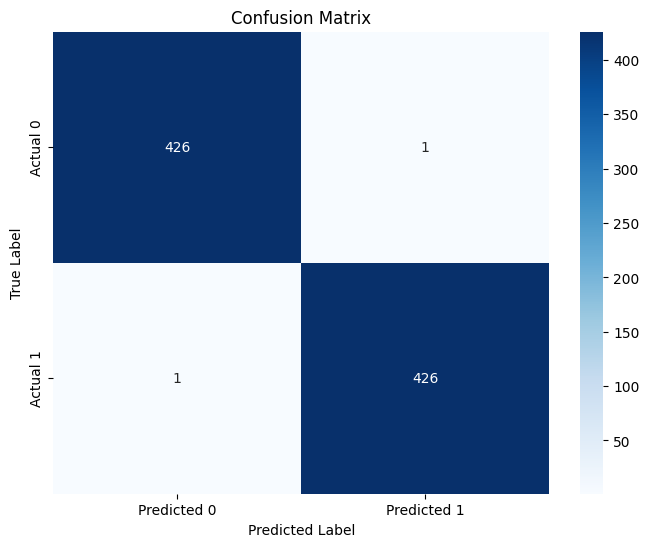

(0.9976580796252927,
 0.9976580796252927,
 0.9976580796252927,
 0.9976580796252927)

In [ ]:
calculate_metrics(Y_train.flatten(), predictions)